In [1]:
import torch
from bbox_utils import *
import torch
from torch import nn
import torch.optim as optimizer
import torch.nn.functional as f
from pathlib import Path
import os
import bbox_utils
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Conv2d, Dropout, MaxPool2d, BatchNorm1d, BatchNorm2d
import pandas as pd
import json
import visualization
import model
import torchmetrics
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from bbox_aug import *
from data_aug import *

C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Target vector length 225


In [2]:
new_size = model.IMAGE_SIZE[0]
ratio = int(512/new_size)

def resize_bbox_rowwise(row):
    return np.array(bbox_utils.transformsBbox(row['bbox'], ratio), dtype='float64')

def resize_im_rowwise(row):
    return bbox_utils.transformsImg(row['path'], new_size)


In [21]:
#Loading the model

dir_root = os.path.abspath('')
model_dir = Path(dir_root, '../data\model/2022-12-10 13_38_46/model/epoch_59.pth') # replace here the name of the model you want to use

In [4]:
train_imgs = Path(dir_root, '../data/train')
test_imgs = Path(dir_root, '../data/test')
annot_dir = Path(dir_root, '../data/annot/rareplanes.json')

In [5]:
with open(annot_dir) as json_data:
    data = json.load(json_data)

annot_train = pd.DataFrame(data['categories'])
annot_train.drop(['loc_id', 'cat_id', 'location', 'role', 'role_id', 'is_plane', 'num_engines', 'propulsion', 'canards', 'num_tail_fins', 'wing_position', 'wing_type',
                'length', 'wingspan', 'area', 'faa_wingspan_class', 'Public_Train', 'Public_Test', 'partialDec', 'truncated', 'new_area', 'area_pixels', 'id'], axis=1, inplace=True)
annot_train.rename(columns={"image_fname": "name"}, inplace=True)

annot_train = annot_train.groupby(['image_id']).agg(
    tuple).applymap(np.array).reset_index()

annot_train.drop(annot_train.index.to_list()[100:], axis=0, inplace=True)

annot_train['path'] = annot_train.apply(
    lambda row: str(train_imgs) + "/"+row['name'][0], axis=1)
annot_train.drop(['name', 'image_id'], axis=1, inplace=True)

In [6]:
annot_train['image'] = annot_train.apply(resize_im_rowwise, axis=1)
annot_train['bbox'] = annot_train.apply(resize_bbox_rowwise, axis=1)
annot_train.head()

,bbox,path,image
0,"[[0.0, 113.0, 30.0, 127.0]]",c:\Users\lucas\OneDrive\Documents\GitHub\aircr...,"[[[53, 45, 38], [54, 45, 39], [69, 60, 51], [5..."
1,"[[61.0, 59.0, 73.0, 66.0], [63.0, 0.0, 73.0, 5...",c:\Users\lucas\OneDrive\Documents\GitHub\aircr...,"[[[27, 23, 24], [22, 20, 19], [18, 17, 16], [2..."
2,"[[8.0, 116.0, 39.0, 127.0]]",c:\Users\lucas\OneDrive\Documents\GitHub\aircr...,"[[[15, 19, 11], [15, 19, 12], [20, 24, 15], [1..."
3,"[[26.0, 5.0, 42.0, 18.0], [75.0, 42.0, 86.0, 5...",c:\Users\lucas\OneDrive\Documents\GitHub\aircr...,"[[[103, 88, 71], [31, 25, 22], [119, 93, 76], ..."
4,"[[114.0, 59.0, 120.0, 64.0], [123.0, 48.0, 127...",c:\Users\lucas\OneDrive\Documents\GitHub\aircr...,"[[[64, 52, 45], [70, 57, 50], [58, 47, 40], [5..."


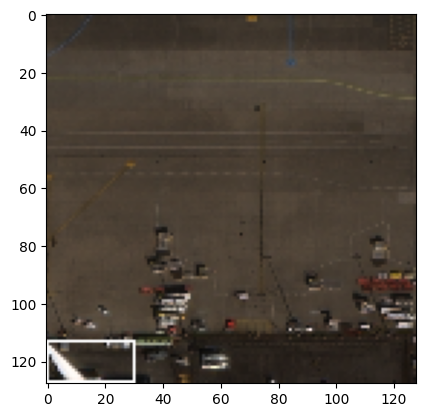

In [7]:
image_idx = 0

plotted_img = draw_rect(annot_train['image'][image_idx], annot_train['bbox'][image_idx])
plt.imshow(plotted_img)
plt.show()

In [8]:
aircraft_model = model.AircraftModel()
aircraft_model.load_weights(model_dir)
aircraft_model.eval()

AircraftModel(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): LeakyReLU(negative_slope=0.1)
    (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.1)
    (11): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

Real bbox:  0                           [[0.0, 113.0, 30.0, 127.0]]
1     [[61.0, 59.0, 73.0, 66.0], [63.0, 0.0, 73.0, 5...
2                           [[8.0, 116.0, 39.0, 127.0]]
3     [[26.0, 5.0, 42.0, 18.0], [75.0, 42.0, 86.0, 5...
4     [[114.0, 59.0, 120.0, 64.0], [123.0, 48.0, 127...
                            ...                        
95    [[53.0, 33.0, 91.0, 57.0], [70.0, 109.0, 110.0...
96    [[88.0, 2.0, 101.0, 10.0], [87.0, 28.0, 104.0,...
97    [[28.0, 104.0, 39.0, 112.0], [40.0, 0.0, 52.0,...
98    [[0.0, 80.0, 6.0, 93.0], [22.0, 56.0, 33.0, 66...
99    [[87.0, 89.0, 104.0, 95.0], [108.0, 91.0, 124....
Name: bbox, Length: 100, dtype: object


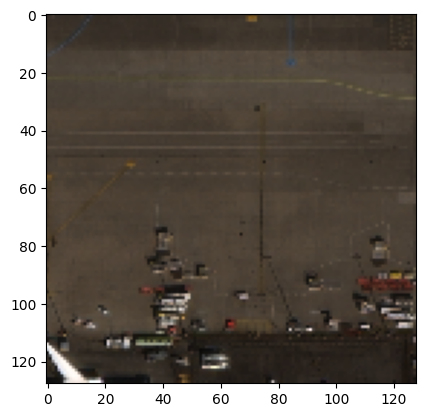

boxes tensor([[  0.0,   0.0,  44.0,  44.0],
        [  0.0,   0.0,  76.0,  44.0],
        [  0.0,   0.0,  44.0,  76.0],
        [  0.0,   0.0,  33.7,  33.7],
        [  0.0,   0.0,  55.3,  33.7],
        [  0.0,   0.0,  33.7,  55.3],
        [  2.0,   2.0,  23.3,  23.3],
        [  0.0,   2.0,  33.7,  23.3],
        [  2.0,   0.0,  23.3,  33.7],
        [  0.0,   5.0,  44.0,  69.0],
        [  0.0,   5.0,  76.0,  69.0],
        [  0.0,   0.0,  44.0, 101.0],
        [  0.0,  16.0,  33.7,  58.7],
        [  0.0,  16.0,  55.3,  58.7],
        [  0.0,   0.0,  33.7,  80.3],
        [  2.0,  27.0,  23.3,  48.3],
        [  0.0,  27.0,  33.7,  48.3],
        [  2.0,  16.0,  23.3,  58.7],
        [  0.0,  30.0,  44.0,  94.0],
        [  0.0,  30.0,  76.0,  94.0],
        [  0.0,   0.0,  44.0, 126.0],
        [  0.0,  41.0,  33.7,  83.7],
        [  0.0,  41.0,  55.3,  83.7],
        [  0.0,  20.0,  33.7, 105.3],
        [  2.0,  52.0,  23.3,  73.3],
        [  0.0,  52.0,  33.7,  73.3],
      

ValueError: expected sequence of length 1 at dim 1 (got 11)

In [67]:
import training_utilities
import random
import importlib
import numpy as np
from pprint import pprint

importlib.reload(visualization)


THRESHHOLD = 0.5
mAP_treshhold = 0
inputs = torch.from_numpy(np.array([annot_train['image'][image_idx]], dtype = "float64")/255)
inputs = torch.permute(inputs, (0, 3, 1, 2))

output = aircraft_model(inputs)
targets = training_utilities.calculate_target_vector(annot_train['bbox'][image_idx])

###

predicted_bboxs = model.np_bboxs #[output[0] >= mAP_treshhold]
labels_predicted_bboxs = np.zeros(len(predicted_bboxs))

real_bboxs = annot_train['bbox']
labels_real_bboxs = np.zeros(len(real_bboxs))


###


print("Real bbox: ", real_bboxs)
#print("Predicted bbox: ", predicted_bboxs.dtype)

visualization.display_bbox_target_vector(annot_train['image'][image_idx], output[0], model.np_bboxs, THRESHHOLD)

boxes = torch.from_numpy(predicted_bboxs)
print("boxes", boxes)


preds = [dict(
            boxes = torch.from_numpy(predicted_bboxs),
            scores= output,
            labels=torch.tensor(labels_predicted_bboxs),
            )
        ]

targ = [dict(
            boxes = torch.tensor(real_bboxs),
            labels=torch.tensor(labels_real_bboxs),
            )
        ]




#targ = [dict(real_bboxs)]

metric = MeanAveragePrecision()
metric.update(preds, targ)

pprint(metric.compute())